# UNDERSTANDING CUSTOMER SHOPPING BEHAVIOR
<br>
•	<b>Purpose/ Business Statement:</b><br>
Optimize effectiveness of online grocery shopping market: <br>
How to understand customer behavior?<br>
How to manage inventory in an efficient way?<br>
<br><br>
•	<b>Statistical interpretation of the business problem:</b><br>
Question 1 – Customer segmentation based on time of order and composition of order (Clustering model)<br>
Question 2 – Order forecasting based on customer ordering history (Predictive model) <br><br>

<b>Approach:</b><br>
A series of exploratory analysis was done to analyze user’s behavior and understand their shopping patterns and unsupervised clustering method was used to cluster users. The segmentation helps understand the demand on a higher level. To dig into the user level, a forecasting model is built to predict order composition of each user. Here, statistical machine learning algorithms  for predictive analysis have been used. 
The outcome of this study will divide Instacart users into different segments based on their shopping behavior and predict future orders of these users. This information can then be used to handle value-chain, from inventory to manpower requirement, in an efficient way. <br><br>
Part 1 - This notebook contains EDA and customer segmentations which forms clusters of customers based or order time amd order composition. This analysis can be used to understand customer behavior.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import gc
import time
import numpy as np  
from sklearn.model_selection import train_test_split

The data was collected from “https://www.instacart.com/datasets/grocery-shopping-2017”, an open source data provided by Instacart.

In [3]:
#importing dataset
aisles = pd.read_csv('dataset/aisles.csv')
departments = pd.read_csv('dataset/departments.csv')
products_prior = pd.read_csv('dataset/order_products__prior.csv')
products_train = pd.read_csv('dataset/order_products__train.csv')
orders = pd.read_csv('dataset/orders.csv')
products = pd.read_csv('dataset/products.csv')

In [11]:
print("Total number of products: ",products.shape[0])
print("Total number of customers: ",len(set(orders['user_id'])))
print("Total number of orders: ",orders.shape[0])
print("Total number of products in all orders: ",products_prior.shape[0])

Total number of products:  49688
Total number of customers:  206209
Total number of orders:  3421083
Total number of products in all orders:  32434489


In [12]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [13]:
products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [14]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [15]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


# EDA

Distribution of total number of orders each customer before the last order

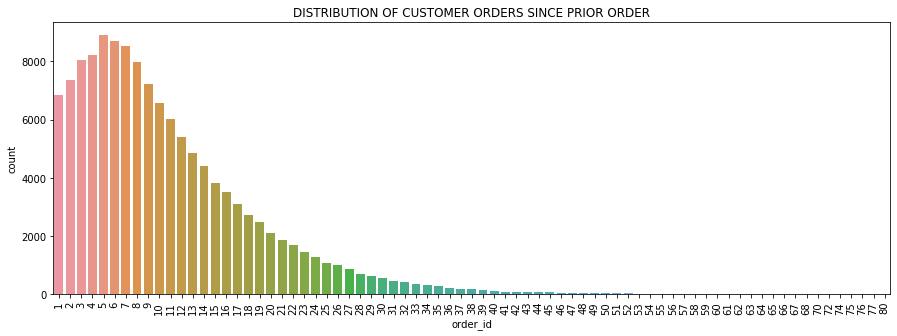

In [16]:
n = products_train['order_id'].value_counts()

plt.figure(figsize=(15,5))
sns.countplot(n)

plt.title('distribution of customer orders since prior order'.upper())
plt.xticks(rotation=90)

plt.show()

Dustribution of number orders w.r.t days of the month

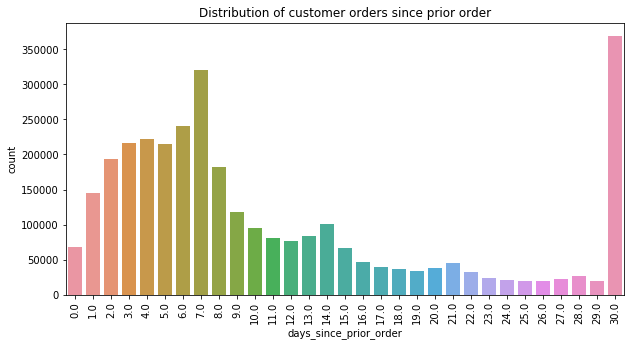

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(orders['days_since_prior_order'])

plt.title('Distribution of customer orders since prior order')
plt.xticks(rotation=90)

plt.show()

Dustribution of number orders w.r.t days of the week

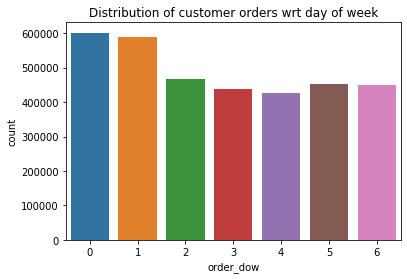

In [18]:
# Effect of day of the w on order volume
sns.countplot(x='order_dow', data =orders)
plt.title('Distribution of customer orders wrt day of week')
plt.show()

Dustribution of number orders w.r.t time of the day

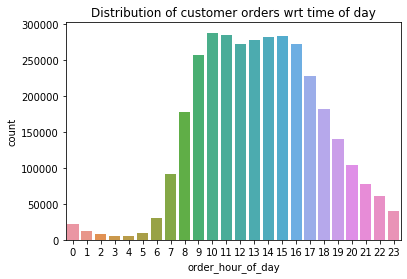

In [19]:
# Effect of hour of day on order volume
sns.countplot(x='order_hour_of_day', data =orders)
plt.title('Distribution of customer orders wrt time of day')
plt.show()

How many times customers reordered?

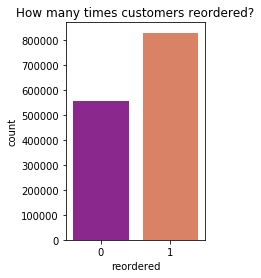

In [21]:
plt.figure(figsize=(2.5,4))
plt.title('How many times customers reordered?')
sns.countplot(x='reordered', data= products_train, palette='plasma')
plt.show()

Combining datasets to group by products and get most popular and most reordered products

In [22]:
prod_imp = products_train[['product_id','reordered']].groupby(['product_id']).mean()
prod_imp['count'] = products_train[['product_id','reordered']].groupby(['product_id']).count()
prod_imp = prod_imp[prod_imp['count']>40]
prod_imp = prod_imp.merge(products, on='product_id')
prod_imp_reorder = prod_imp[['product_name','reordered']].sort_values(by='reordered',ascending=False)
prod_imp_popular = prod_imp[['product_name','count']].sort_values(by='count',ascending=False)

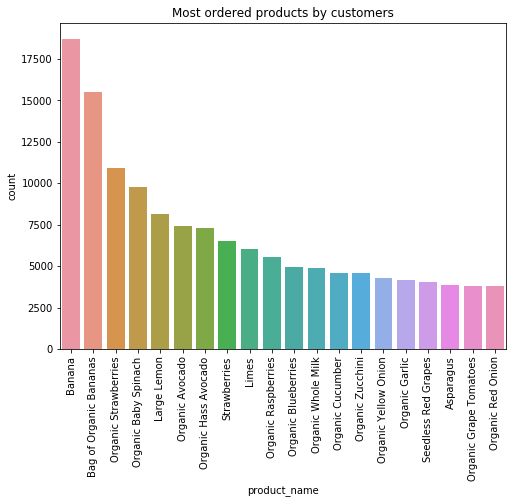

,product_name,count
2666,Banana,18726
1419,Bag of Organic Bananas,15480
2263,Organic Strawberries,10894
2347,Organic Baby Spinach,9784
5143,Large Lemon,8135
5155,Organic Avocado,7409
5106,Organic Hass Avocado,7293
1802,Strawberries,6494
2799,Limes,6033
3003,Organic Raspberries,5546


In [23]:

plt.figure(figsize=(8,6))
sns.barplot(x= prod_imp_popular['product_name'][0:20], y=prod_imp_popular['count'][0:20] )
plt.title('Most ordered products by customers')
plt.xticks(rotation=90)
plt.show()
prod_imp_popular.head(10)

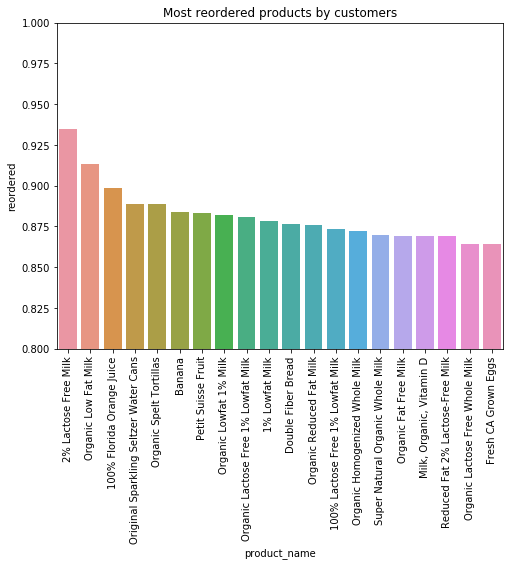

,product_name,reordered
170,2% Lactose Free Milk,0.934783
2237,Organic Low Fat Milk,0.913043
1300,100% Florida Orange Juice,0.898305
3401,Original Sparkling Seltzer Water Cans,0.888889
2249,Organic Spelt Tortillas,0.888889
2666,Banana,0.884172
13,Petit Suisse Fruit,0.883333
4256,Organic Lowfat 1% Milk,0.881988
1326,Organic Lactose Free 1% Lowfat Milk,0.881041
2594,1% Lowfat Milk,0.878525


In [24]:
plt.figure(figsize=(8,6))
sns.barplot(x= prod_imp_reorder['product_name'][0:20], y=prod_imp_reorder['reordered'][0:20] )
plt.title('Most reordered products by customers')
plt.xticks(rotation=90)
plt.ylim(0.8, 1)
plt.show()
prod_imp_reorder.head(10)

Distribution of Organic and Non-organic products

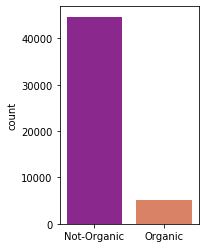

In [6]:
products['Organic or Not'] = products.product_name.str.lower().str.contains('organic')
products['Organic or Not'].replace({True:'Organic', False:'Not-Organic'}, inplace=True)

plt.figure(figsize=(2.5,4))
sns.countplot(products['Organic or Not'], palette='plasma')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('')
plt.show()

what are peoples favorite Aisles?

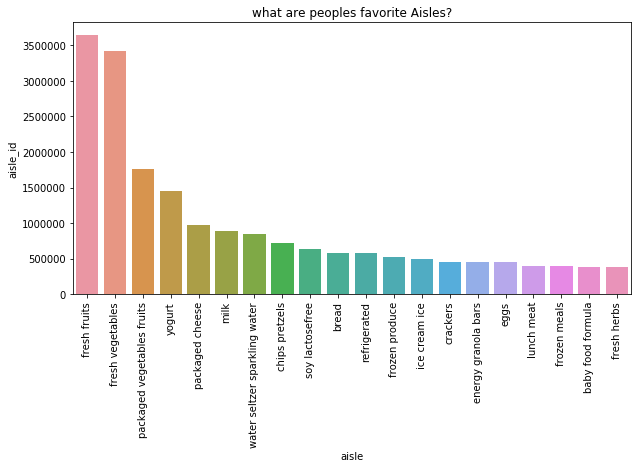

In [26]:
product_aisle = products.merge(aisles, on='aisle_id')
products_prior_aisle = products_prior.merge(product_aisle, on='product_id')
A = products_prior_aisle[['aisle_id','aisle']].groupby(by='aisle').count().sort_values(by='aisle_id', ascending=False)

plt.figure(figsize=(10,5))
plt.title('what are peoples favorite Aisles?')

sns.barplot(x=A.index[0:20], y=A['aisle_id'][0:20])
plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=90)

plt.show()

what are peoples favorite Departments?

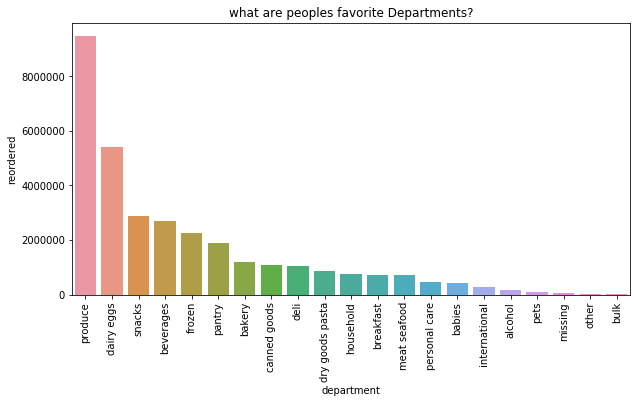

In [27]:
products_prior_aisle_dep = products_prior_aisle.merge(departments, on='department_id')
B= products_prior_aisle_dep[['reordered','department']].groupby('department').count().sort_values(by='reordered', ascending=False)

plt.figure(figsize=(10,5))
plt.title('what are peoples favorite Departments?')

sns.barplot(x=B.index, y=B['reordered'])
plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=90)

plt.show()

How many prior orders are available based on order_numer?

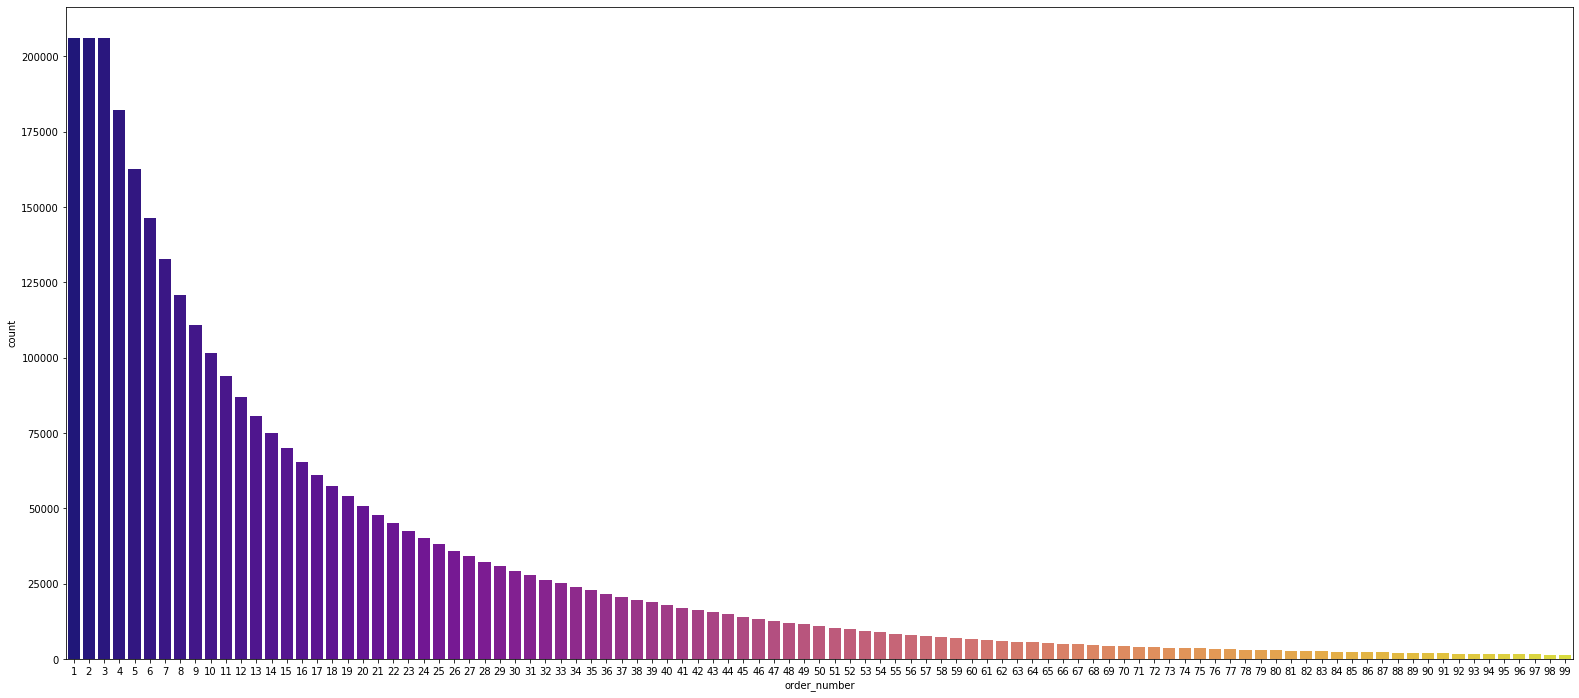

In [30]:
plt.figure(figsize=(27,12))
sns.countplot(x='order_number', data = orders.loc[orders.eval_set=='prior'], palette='plasma')
plt.show()

Effect of add to cart order on being reordered<br>
The sequence of adding products to a cart is highly related to the products being reordered

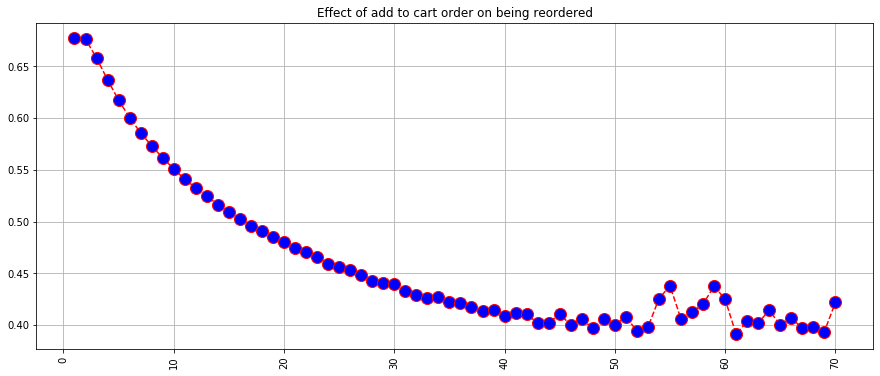

In [31]:
plt.figure(figsize=(15,6))
plt.grid(b=True)
plt.title('Effect of add to cart order on being reordered')
C= products_prior_aisle_dep[['reordered','add_to_cart_order']].groupby('add_to_cart_order').mean()
plt.plot(C.index[0:70], C['reordered'][0:70], color='red', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=12)
plt.xticks(rotation=90)
plt.show()

# Customer Segmentation

## Clustering by time of order

The pattern of ordering should represent the composition of the order. <br><br>
A crosstab distribution between customer ids and days since last order is created which is used used to do PCA. The PCA gives a dataset with 2 dimensions which is used to find clusters.<br>
Same procedure is followed for customer segmentation w.r.t product composition.

In [33]:
### Crosstab for customer shopping pattern
cust_pattern = pd.crosstab(orders['user_id'], orders['days_since_prior_order'])
cust_pattern.head(10)

days_since_prior_order,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,1
2,0,0,0,1,0,0,1,0,3,0,...,0,0,0,0,0,0,1,1,0,3
3,0,0,0,0,0,0,0,4,0,1,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,0,0,1,2,1,1,2,4,1,2,...,0,0,0,0,0,0,0,1,0,2
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [85]:
# PCA
def pca(df):
    pca = PCA(n_components=2)
    pca.fit(df)
    pca_samples = pca.transform(df)
    new_df = pd.DataFrame(pca_samples)
    
    no_clusters = list(range(1,10))
    sse = []
    for n in no_clusters:
        clusterer = KMeans(n_clusters=n,random_state=42).fit(new_df)
        sse.append(clusterer.inertia_)

    plt.figure(figsize=(6, 6))
    plt.plot(no_clusters, sse, '-o')
    plt.xlabel(r'Number of clusters 20')
    plt.ylabel('Sum of squared distance')
    plt.show()
    
    #num = []
    #diff = 1
    #i = 0
    #while diff > 0.05:
     #   diff = (sse[i]-sse[i+1]) / sse[i]
      #  i = i + 1
    #num = i
                
    return new_df #,num

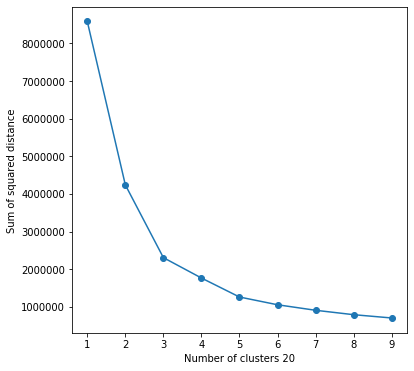

In [86]:
pca_df = pca(cust_pattern)

According to the see condition (change in sse < 5%), the code gives 21 different clusters. For this project I have just considered 4 different clusters to keep the clusters as disjoint as possible. 

In [90]:
def plot_cluster(df,n):    
    clusterer = KMeans(n_clusters=n,random_state=42).fit(df)
    centers = clusterer.cluster_centers_
    c_preds = clusterer.predict(df)
    fig = plt.figure(figsize=(8,8))
    colors = ['orange','blue','purple','green','red']
    colored = [colors[k] for k in c_preds]
    plt.scatter(df[0],df[1],  color = colored)
    for ci,c in enumerate(centers):
        plt.plot(c[0], c[1], 'o', markersize=8, color='black', alpha=0.9, label=''+str(ci))

    plt.xlabel('x_values')
    plt.ylabel('y_values')
    plt.legend()
    plt.show()
    
    return c_preds

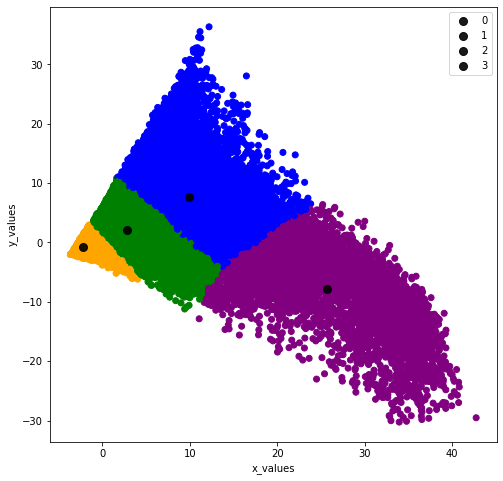

In [92]:
pred = plot_cluster(pca_df,4)

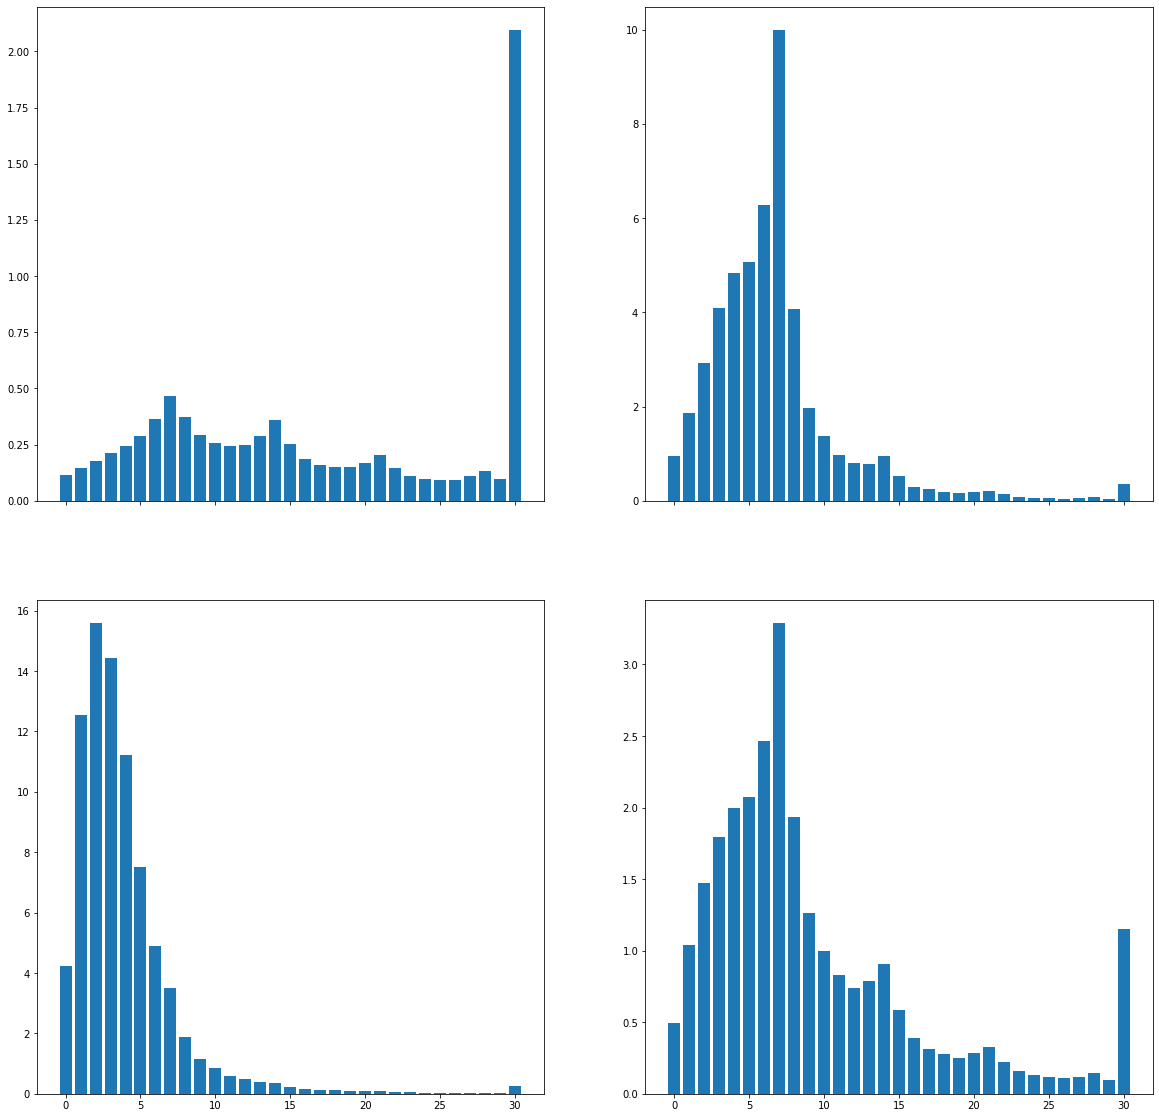

In [93]:
cust_pattern['cluster'] = pred
f,arr = plt.subplots(2,2,sharex=True,figsize=(20,20))

c0 = cust_pattern[cust_pattern['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(cust_pattern.drop('cluster',axis=1).columns)),c0)
c1 = cust_pattern[cust_pattern['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(cust_pattern.drop('cluster',axis=1).columns)),c1)
c2 = cust_pattern[cust_pattern['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(cust_pattern.drop('cluster',axis=1).columns)),c2)
c3 = cust_pattern[cust_pattern['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(cust_pattern.drop('cluster',axis=1).columns)),c3)
plt.show()


The distribution of clusters above shows the patern of ordering w.r.t time of order. Further, I want to check what are the order compositions for each of these clusters.

In [96]:
# Merging all the datasets to find the order composition
prior_data = pd.merge(products_prior,products, on = ['product_id','product_id'])
prior_data = pd.merge(prior_data,orders,on=['order_id','order_id'])
prior_data = pd.merge(prior_data,aisles,on=['aisle_id','aisle_id'])
prior_data = pd.merge(prior_data,departments,on=['department_id','department_id'])

In [104]:
pred = pd.DataFrame(pred,columns=["cluster"])
pred['user_id'] = pred.index
x = pd.merge(prior_data,pred,on=['user_id','user_id'],how="left")

for i in range(0,4):
    x1 = x[x['cluster']==i]
    print("Cluster ", i, " composition:\n\n",x1['product_name'].value_counts()[0:10])
    print("\n\n")

Cluster  0  composition:

 Banana                    353921
Bag of Organic Bananas    284262
Organic Strawberries      198945
Organic Baby Spinach      180610
Organic Hass Avocado      159965
Organic Avocado           132174
Large Lemon               114493
Strawberries              105791
Limes                     105619
Organic Whole Milk        102871
Name: product_name, dtype: int64



Cluster  1  composition:

 Banana                    26520
Bag of Organic Bananas    20706
Organic Strawberries      13806
Organic Baby Spinach      13359
Organic Hass Avocado      11586
Organic Avocado            9439
Strawberries               8348
Large Lemon                8030
Organic Whole Milk         7758
Limes                      7684
Name: product_name, dtype: int64



Cluster  2  composition:

 Banana                    11869
Bag of Organic Bananas     9793
Organic Strawberries       6803
Organic Baby Spinach       6161
Organic Hass Avocado       5144
Organic Avocado            4442
Straw

Above are the order compositions for different clusters. The most frequent products in each clusters are same because the data is highly skewed with fruits and vegetables. To understand the difference in the clusters, we should check the middle products.

## Clustering by composition of order

Finding the clusters based on the products the customers order.<br>
The products are clustered based on the departments the products belonged to.

In [105]:
cust_prod = pd.crosstab(prior_data['user_id'], prior_data['department'])
cust_prod.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,13,3,0,0,13,0,0,...,2,0,0,0,0,1,0,0,5,22
2,0,0,2,9,3,0,1,48,21,0,...,0,3,1,0,0,11,1,0,36,42
3,0,0,0,3,0,0,0,21,2,4,...,1,0,0,0,0,4,0,0,38,9
4,2,0,2,3,0,0,1,0,2,0,...,2,0,0,0,0,0,0,0,2,1
5,0,0,0,0,0,0,1,8,1,1,...,0,2,0,0,0,2,0,0,19,1


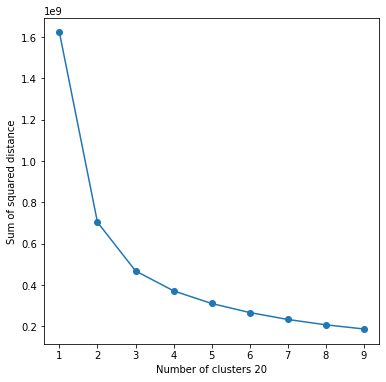

In [107]:
pca_df = pca(cust_prod)

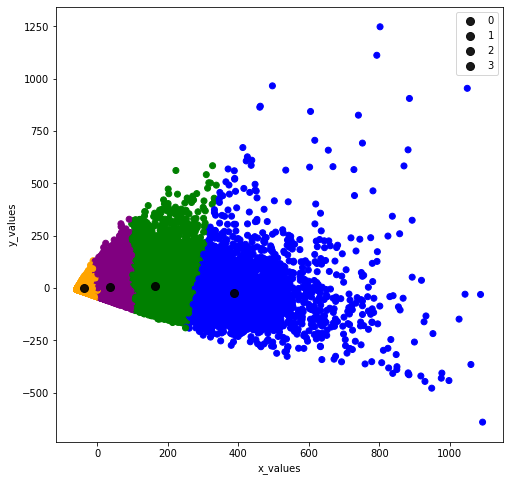

In [109]:
pred = plot_cluster(pca_df,4)

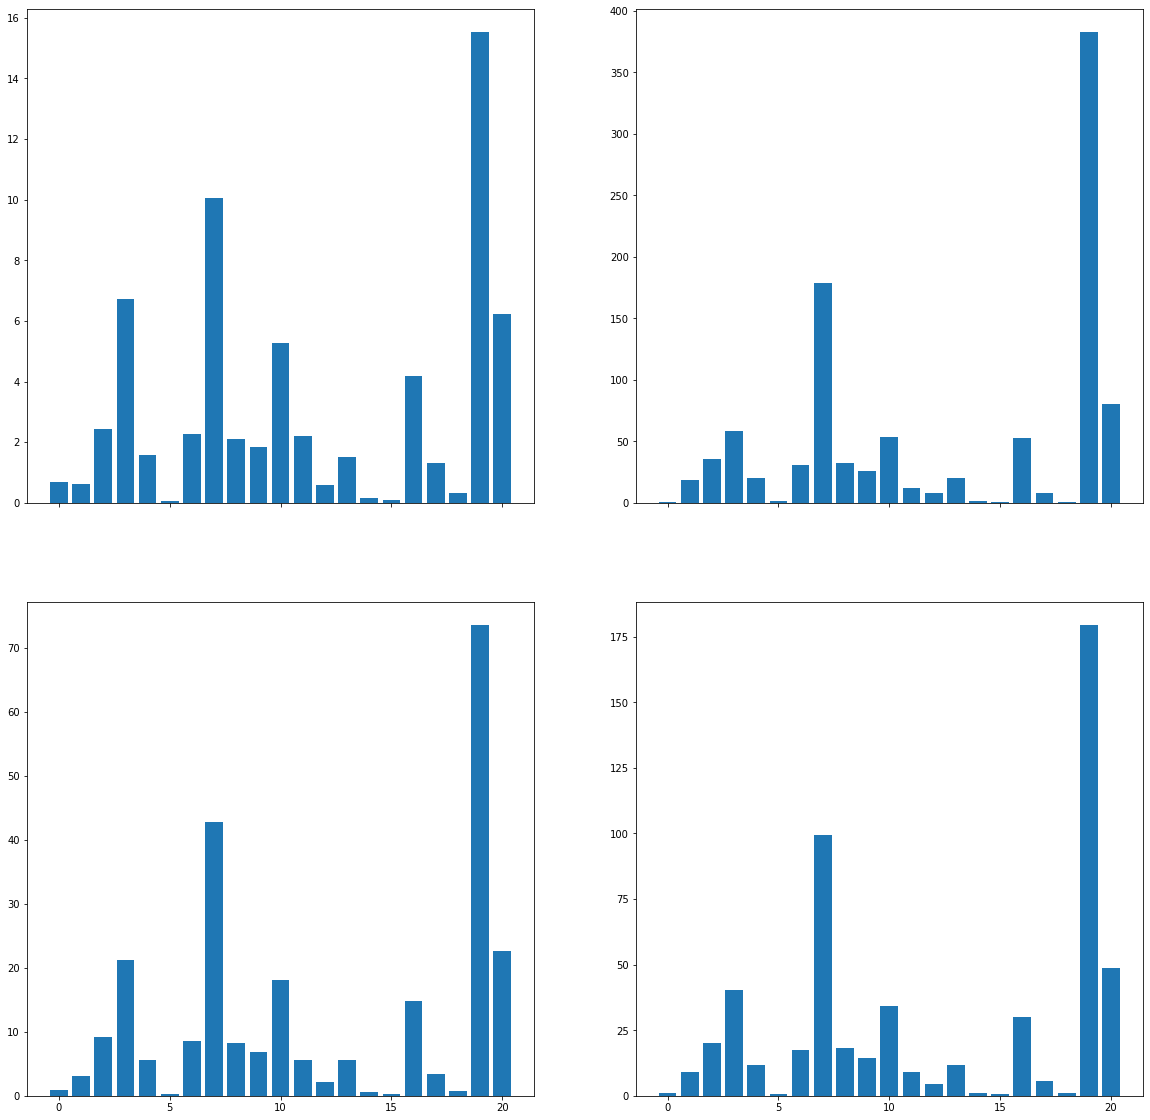

In [111]:
cust_prod['cluster'] = pred
f,arr = plt.subplots(2,2,sharex=True,figsize=(20,20))

c0 = cust_prod[cust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(cust_prod.drop('cluster',axis=1).columns)),c0)
c1 = cust_prod[cust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(cust_prod.drop('cluster',axis=1).columns)),c1)
c2 = cust_prod[cust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(cust_prod.drop('cluster',axis=1).columns)),c2)
c3 = cust_prod[cust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(cust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()

The cluster distributions gives the different department distribution. <br>
Further I check the distribution of products in each cluster.

In [112]:
pred = pd.DataFrame(pred,columns=["cluster"])
pred['user_id'] = pred.index
x = pd.merge(prior_data,pred,on=['user_id','user_id'],how="left")

for i in range(0,4):
    x1 = x[x['cluster']==i]
    print("Cluster ", i, " composition:\n\n",x1['product_name'].value_counts()[0:10])
    print("\n\n")

Cluster  0  composition:

 Banana                    334967
Bag of Organic Bananas    268532
Organic Strawberries      187186
Organic Baby Spinach      172178
Organic Hass Avocado      151514
Organic Avocado           124733
Large Lemon               107659
Strawberries              100447
Limes                     100416
Organic Raspberries        97075
Name: product_name, dtype: int64



Cluster  1  composition:

 Banana                    9276
Bag of Organic Bananas    7544
Organic Strawberries      4951
Organic Baby Spinach      4567
Organic Hass Avocado      3927
Organic Avocado           3574
Strawberries              2939
Organic Whole Milk        2778
Large Lemon               2713
Organic Raspberries       2543
Name: product_name, dtype: int64



Cluster  2  composition:

 Banana                    94429
Bag of Organic Bananas    76186
Organic Strawberries      53645
Organic Baby Spinach      47774
Organic Hass Avocado      42663
Organic Avocado           36197
Large Lemon    

This segmentation analysis will give the understanding of customer preferences. And ideally the clusters we got from both the clustering models should resemble similar customer behavior.

Please refer the forecasting notebook for further analysis.